# __This Notebook is still a *Work in Progress*__

# A Hitchhiker's Guide to Indian Patent Analytics

This notebook is intended to be read with the article of the same title [published on LinkedIn](https://www.linkedin.com/pulse/draft/AgGvJ9CZkdm63AAAAWZmrUzA6jtaXXUHIq2OjKruZEKaxFrRZp1Adc-nunE7H5pnVU8DakU).

This article shows how patent Informatics studies of Indian patent data can be performed using entirely free tools and patent databases. The power of such techniques is certainly limited, but as the featured example shows, even certain moderately sophisticated studies can be performed. The results of such studies are valuable on their own, but these efforts are also effective learning and training aids, and are also very useful for planning larger patent informatics projects before investing in commercial tools and resources.

The approach described here has been usable [since mid-March 2018](http://www.wipo.int/patentscope/en/news/pctdb/2018/news_0002.html) when Indian patent data became available at [WIPO](http://www.wipo.int)'s patent-search portal [PATENTSCOPE](https://patentscope.wipo.int/). The crucial enabler is the *PATENTSCOPE* feature that allows search results to be downloaded to the user's computer for further processing. The result of searches performed on the Indian Patent Office's search portal [inPASS](https://ipindiaservices.gov.in/publicsearch) can not be downloaded.

### Structure of this Notebook

This notebook deals with knowledge from two very different domains: *patent search* (see [wipo](http://www.wipo.int/patents), [wikipedia](https://en.wikipedia.org/wiki/Patent)), and *machine learning* (see [wikipedia](https://en.wikipedia.org/wiki/Machine_learning)), and the article also has two sections with corresponding titles. The first part, *Patent Search*, can be read and undertood well even by those without a background in patents. But the second part, *Machine Learning*, is considerably more specialized, and is likely to be confusing for most patent professionals. Despite the hype surrounding machine learning (see [Data Scientist: The Sexiest Job of the 21st Century](https://hbr.org/2012/10/data-scientist-the-sexiest-job-of-the-21st-century)) it still remains a very niche skill, so even getting a feel for the possibilities that these techniques open up is probably a win.

The last part of the article, titled *Conclusions*, summarizes the main takeaways from the article.

### What is Patent Analytics?

Patent analytics, patent informatics or just *patinformatics*, [has been defined as](https://pdfs.semanticscholar.org/bcd7/beec3e15a7351a98b402e9fd84ef82f841d7.pdf) 
"*the science of analyzing patent information to discover relationships and trends*", 
and as "*... a macro-level science, that is analysis that deals with large quantities of patent information*". 
You can read more about it in the Wikipedia article on [Patent Visualization](https://en.wikipedia.org/wiki/Patent_visualisation).

The result of a patent analytics project is often expressed as charts, graphs, plots, and maps. Examples can be seen in slide 8 of [Spatial Concept Mapping as a Patent Landscaping Task](http://www.wipo.int/edocs/mdocs/mdocs/en/wipo_ip_rio_13/wipo_ip_rio_13_www_17.pdf) (PDF) and the topic maps in [this patent portfolio analysis](https://www.relecura.com/reports/Relecura_Whitepaper_-_Topic_Maps.pdf). A list of commercial patent analytics tools can be found in [Patent Analysis, Mapping, and Visualization Tools](https://wiki.piug.org/display/PIUG/Patent+Analysis%2C+Mapping%2C+and+Visualization+Tools).

### The Example Project

(To be Defined)

## Part-1. Patent Search

This part explains how the patent data used for this analysis was downloaded as an [Excel spreadsheet](https://en.wikipedia.org/wiki/Microsoft_Excel) from PATENTSCOPE. Since the analysis requires a good number of patent applications from two competing organizations in the same industry, [Tata Steel](https://en.wikipedia.org/wiki/Tata_Steel) and [Steel Authority of India](https://en.wikipedia.org/wiki/Steel_Authority_of_India) were selected. These two organizations are sufficiently similar to be effective as sources of data for a comparative study of this nature.

### Search Parameters

The first step is to select Field Combination from the Search menu as seen in Figure-1 below.

<br/>
<br/>
<img src="patentscope-011.png" height="75%" width="75%"/><br/>
__Figure-1. Selecting "Field Combination" search__
<br/>
<br/>

When *Field Combination* is selected, the form expands to accommodate the choice of a large number of input parameters. To obtain the data for this exercise, three search fields were used as seen in Figure-2 below.

<br/>
<br/>
<img src="patentscope-025.png" height="75%" width="75%"/><br/>
__Figure-2. Entering search parameters__
<br/>
<br/>

Setting *Office Code* to *IN* indicates our interest in data only from the Indian Patent Office. Setting *Applicant Name* as shown above yields applications from the two companies we chose earlier, and setting the *Publication Date* as shown limits the applications listed to those published in the last 5 years. Observe that the number of records matching the search criteria is shown at the bottom of the screen to the left of the *Search* button. The data produced by these settings is convenient for illustrating the ideas described in this article. You can read about the other settings and features in PATENTSCOPE's extensive [User's Guide](https://patentscope.wipo.int/search/en/help/users_guide_summer2017.pdf) (PDF).

### Downloading Results

Clicking the Search button near the bottom right displays the results screen seen in Figure-3 below.

<br/>
<br/>
<img src="patentscope-038.png" height="75%" width="75%"/><br/>
__Figure-3. Search results screen__
<br/>
<br/>

The 592 records (red highlight near top-left) found can be downloaded as an Excel spreadsheet by clicking the download icon marked *10K* (red highlight near top-right). Observe that it is necessary to be logged in as an authorized user to be able to download the results.

A free PATENTSCOPE account permits users to download *some* data, and the free quota is fortunately adequate for this demo exercise. Searches that produce large volumes of result data may, however, need to use a paid account. 

## Part-2. Machine Learning

This description is provided only for publications of the content of this notebook in other media (e.g. LinkedIn)

The following text and code 

### Preliminaries

In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Load Excel File Downloaded from Patentscope

In [3]:
df = pd.read_excel('resultList2.xls', 'ResultSet')
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

print('Data has %d rows and %d columns' % df.shape)
print('Column names: %s' % ', '.join(df.columns))

Data has 592 rows and 11 columns
Column names: application_id, application_number, publication_number, publication_date, title, priority_data, ipc, applicants, inventors, fp_image, nat_phase_entries


# Preliminary Data Analysis and Enrichment

### Add a *company* column

In [4]:
df['company'] = np.where(df['applicants'].str.contains('TATA STEEL'), 
    'TATA', 'SAIL')

### Calculate and Display Relative Patent Counts

TATA    374
SAIL    218
Name: company, dtype: int64



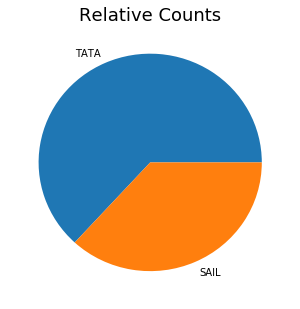

In [5]:
counts = df['company'].value_counts()

print(counts)
print('')

ax = counts.plot.pie(figsize=(5, 5))
ax.set_title('Relative Counts', fontsize=18)
ax.set_ylabel('')
None

### Display Some Sample Data

In [6]:
df[['publication_number', 'publication_date', 'title', 'ipc', 'company', 'inventors']].sample(5)

,publication_number,publication_date,title,ipc,company,inventors
515,IN1588/KOL/2011,26.08.2016,A SYSTEM FOR CHOCKING DETECTION OF ANY PERFORA...,E21B 43/12,SAIL,RAY UTTAM KUMAR
281,IN201631031494,16.03.2018,A METHOD FOR CONTROLLING THE SUPERHEAT OF LIQU...,C21B 7/00;C21B 5/00;C21B 13/00,TATA,MR. ANURAG TRIPATHI;MS. SOUMYA NALLURI;MR. HAR...
43,IN201631004217,10.11.2017,A PROCESS FOR THE DECARBURIZATION OF LOW- MAN...,C21D 6/00,TATA,VEERENDRA SINGH;ARIJIT BISWAS;SUBRATA MUKHERJEE
142,IN171/KOL/2010,24.07.2015,A WATER-BASED LUBRICANT COMPOSITION FOR METAL ...,C10M 10/14,TATA,RITA GHOSH;NIKHILESH BANDYOPADHYAY;SUNITESH DA...
50,IN201631008556,10.11.2017,AN IMPROVED TUNDISH BOTTOM DESIGN TO MINIMIZE ...,C22C 33/04,TATA,Abhishek Chakraborty;Vikas Singh;Alok Kumar;Na...


# *Feature Engineering* -- Convert IPC codes into Text (*Sentences*)

Convert the IPC codes into *sentences* to facilitate subsequent processing with scikit-learn's [text-feature-extraction](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) capabilities.

### Extract IPC codes into arrays

In [7]:
ipc_regex = re.compile('[A-H]\s*[0-9]{2}\s*[A-Z]\s*(?:[0-9]+(?:/(?:[0-9]+)?)?)?')

df['ipc_list'] = df['ipc'].str.findall(ipc_regex)
df = df[df['ipc_list'].str.len() != 0]

print('Count of records with IPCs: %d' % len(df))
ipclen = df['ipc_list'].str.len()
print('IPC nbr: min=%d, mean=%f, max=%d' % (ipclen.min(), ipclen.mean(), ipclen.max()))

Count of records with IPCs: 588
IPC nbr: min=1, mean=1.406463, max=4


### IPC to Sentence Converter

In [8]:
ipc_pattern = '([A-H])\s*(?:(\d{2})\s*(?:([A-Z])\s*(?:(\d+)\s*(?:/\s*(\d+))?)?)?)?'
ipcregex = re.compile(ipc_pattern)

def ipc_sentence(ipc):
    parts = [part.strip('[ /]') for part in re.match(ipcregex, ipc).groups() if part]
    s = parts[0]
    if len(parts) > 1:
        s += ' ' + parts[0] + parts[1]
        if len(parts) > 2:
            s += ' ' + parts[0] + parts[1] + parts[2]
            if len(parts) > 3:
                s += ' ' + parts[0] + parts[1] + parts[2] + parts[3]
                if len(parts) > 4:
                    s += ' ' + parts[0] + parts[1] + parts[2] + parts[3] + parts[4]
    return s

def multi_ipc_sentence(ipcs):
    return ' '.join([ipc_sentence(ipc) for ipc in ipcs])

### Test IPC to Sentence Conversion

In [9]:
multi_ipc_sentence(['A 13 K 127 / 999'])

'A A13 A13K A13K127 A13K127999'

### Convert all IPC Codes

### Display Converted Sentence Samples

In [10]:
ipc_sentence = df['ipc_list'].map(multi_ipc_sentence)
ipc_sentence.sample(10)

431                           F F16 F16K F16K31 F16K3100
429                           H H02 H02J H02J13 H02J1300
522                             F F24 F24J F24J2 F24J240
174                           B B01 B01D B01D63 B01D6316
132    B B32 B32B B32B15 B32B1501 C C22 C22C C22C38 C...
408                            G G01 G01B G01B5 G01B5213
302    G G01 G01R G01R31 G01R3100 G G01 G01N G01N3 G0...
348    C C22 C22C C22C38 C22C3800 C C22 C22C C22C38 C...
509                           C C21 C21D C21D11 C21D1100
259                           B B82 B82Y B82Y30 B82Y3000
Name: ipc_list, dtype: object

# Apply Text-Processing Techniques

### Generate TF-IDF Word Counts

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(use_idf=True, stop_words='english').fit(ipc_sentence)
tf = vectorizer.transform(ipc_sentence)
print('Rows: %d, Features: %d' % tf.shape)

Rows: 588, Features: 984


# Prepare Word Counts for Scatter Plot Display

### Use TruncatedSVD to Reduce to 50 Features

In [12]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=50)
tsvd100 = tsvd.fit_transform(tf)
print('Rows: %d, Features: %d' % tsvd100.shape)

Rows: 588, Features: 50


### Use t-SNE to Obtain 2-D (X, Y) Mapping

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(tsvd100)
print('Rows: %d, Features: %d' % tsne.shape)

Rows: 588, Features: 2


In [18]:
tsne[:10, :]

array([[-24.3688736 ,  14.39007759],
       [  9.09978199,   1.02944446],
       [ 10.35545826,  -8.10030556],
       [ 15.68829155,  -2.74155211],
       [ -6.04882145,  -4.24504471],
       [ -0.49821216,   7.1280508 ],
       [-14.48755455, -18.78851509],
       [-12.86696815, -20.67894936],
       [-23.49485016,   0.44699791],
       [ 11.85651684,  14.91254044]], dtype=float32)

### Scatter Plot of 2-D Data

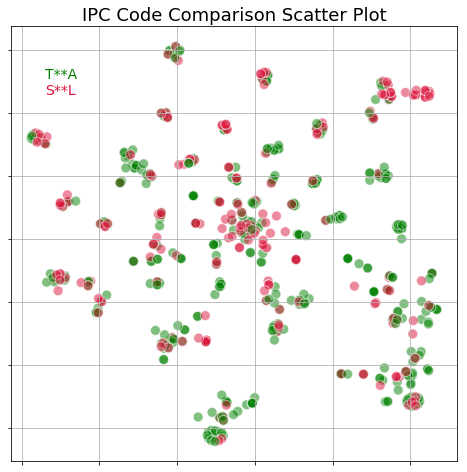

In [25]:
color1 = 'green'
color2 = 'crimson'
tsne_df = pd.DataFrame(tsne, columns=['x', 'y'])
colors = np.where(df['company'] == 'TATA', color1, color2)
ax = tsne_df.plot.scatter(x='x', y='y', figsize=(8, 8), grid=True, 
   alpha=0.5, color=colors, edgecolors='white', s=96)
ax.set_xlabel('')
ax.set_ylabel('')
ax.text(-27, 25.5, 'T**A', color=color1, fontsize=14)
ax.text(-27, 23, 'S**L', color=color2, fontsize=14)
ax.set_title('IPC Code Comparison Scatter Plot', fontsize=18)
ax.set_xticklabels(['' for i in range(6)])
ax.set_yticklabels(['' for i in range(7)])
plt.savefig('ipc-scatter-tsne.png')
None

### Use UMAP to Obtain 2-D (X, Y) Mapping

In [15]:
import umap

umap2d = umap.UMAP().fit_transform(tf)

print('Rows: %d, Features: %d' % umap2d.shape)

Rows: 588, Features: 2


In [17]:
umap2d[:10, :]

array([[  5.94781971,   5.96396017],
       [  6.74260616,   7.05643606],
       [  3.30957913,   6.57019329],
       [  5.8342948 ,  -2.38169169],
       [  5.28762865,   8.43028259],
       [  5.11947155,  -1.57347298],
       [ -9.3924408 ,  -4.69294977],
       [-10.13637733,  -4.8942275 ],
       [  7.09280348,  -8.51702595],
       [ -2.62122393,   7.61612654]], dtype=float32)

### Scatter Plot of 2-D Data

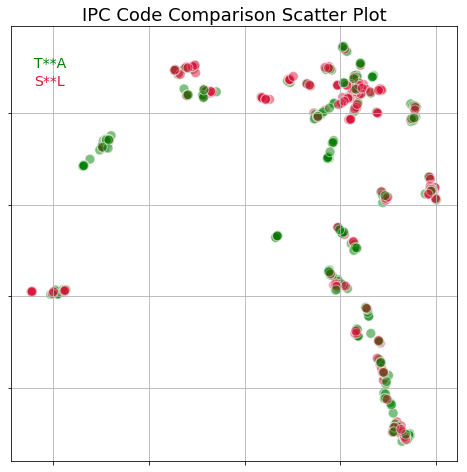

In [24]:
color1 = 'green'
color2 = 'crimson'
umap_df = pd.DataFrame(umap2d, columns=['x', 'y'])
colors = np.where(df['company'] == 'TATA', color1, color2)
ax = umap_df.plot.scatter(x='x', y='y', figsize=(8, 8), grid=True, 
   alpha=0.5, color=colors, edgecolors='white', s=96)
ax.set_xlabel('')
ax.set_ylabel('')
ax.text(-11, 7.5, 'T**A', color=color1, fontsize=14)
ax.text(-11, 6.5, 'S**L', color=color2, fontsize=14)
ax.set_title('IPC Code Comparison Scatter Plot', fontsize=18)
ax.set_xticklabels(['' for i in range(6)])
ax.set_yticklabels(['' for i in range(7)])
plt.savefig('ipc-scatter-umap.png')
None

# (Draft) The Example Project

![IPC Scatter Plot](ipc-scatter-article.png)

Each colored point on this scatter plot depicts an IPC code from a patent application of one company (identified by color). Points on such [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) mapping diagrams are located so that "... *similar objects are modeled by nearby points and dissimilar objects are modeled by distant points* ..." (quoted from [Wikipedia](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)). Any cluster of points all of the same color therefore could possibly be a strong group of related patents -- a matter of some concern to the other company. Such maps are useful for the identification of strong patent groups, white-spaces and [thickets](https://en.wikipedia.org/wiki/Patent_thicket) in the evaluation of competitive strengths.

The input data used for this notebook (the Excel file named *resultList2.xls*) was downloaded earlier and then cleaned using a process described in the LinkedIn article.